In [1]:
from cideMOD import (
    CellParser,
    ErrorCheck,
    NDProblem,
    Problem,
    SolverCrashed,
    Trigger,
    init_results_folder,
    ModelOptions,
)

In [2]:
overwrite = True
case = "Chen_2020"
data_path = "../data/data_{}".format(case)
params = "params_tuned.json"

model_options = ModelOptions(mode='P2D', clean_on_exit=False)

save_path = init_results_folder(
    case, overwrite=overwrite, copy_files=[f"{data_path}/{params}"]
)

Saving results to /home/fenics/shared/cideMOD/examples/results_Chen_2020


In [3]:
cell = CellParser(params, data_path=data_path)
problem = Problem(cell, model_options, save_path=save_path)
problem.set_cell_state(1, 273 + 25, 273 + 25)
problem.setup()
C_rate = -1
I_app = -5 #C_rate * problem.Q
t_f = 3600 /abs(C_rate)*1.25

Capacidad Anodo: 5.090421993425188
Capacidad Catodo: 5.574712396434605
Capacidad Celda: 5.090421993425188
Building mesh for P2D problem with 3 components and 90 nodes.
Finished building mesh
Building problem setup
 - Build cell parameters - Done 
 - Initializing state - Done 
 - Build variational formulation - Done 
Problem Setup finished.
Problem has 432.0 dofs.



In [4]:
v_min = Trigger(2.5, "v")
status = problem.solve_ie(
    min_step=5, i_app=I_app, t_f=t_f, store_delay=10, adaptive=True, triggers=[v_min]
)
err = ErrorCheck(problem, status)

if isinstance(status, SolverCrashed):
    raise status.args[0]

Solving ...
Voltage is 2.5 V at 3550.00 s 0	Time: 59min 5sK



# Compare results

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
voltage_data_1C = pd.read_csv("../data/data_Chen_2020/V_1C_Chen.txt", header=None, sep=' ').to_numpy()
voltage_pybamm_1C = pd.read_csv("Chen_1C.csv").to_numpy()

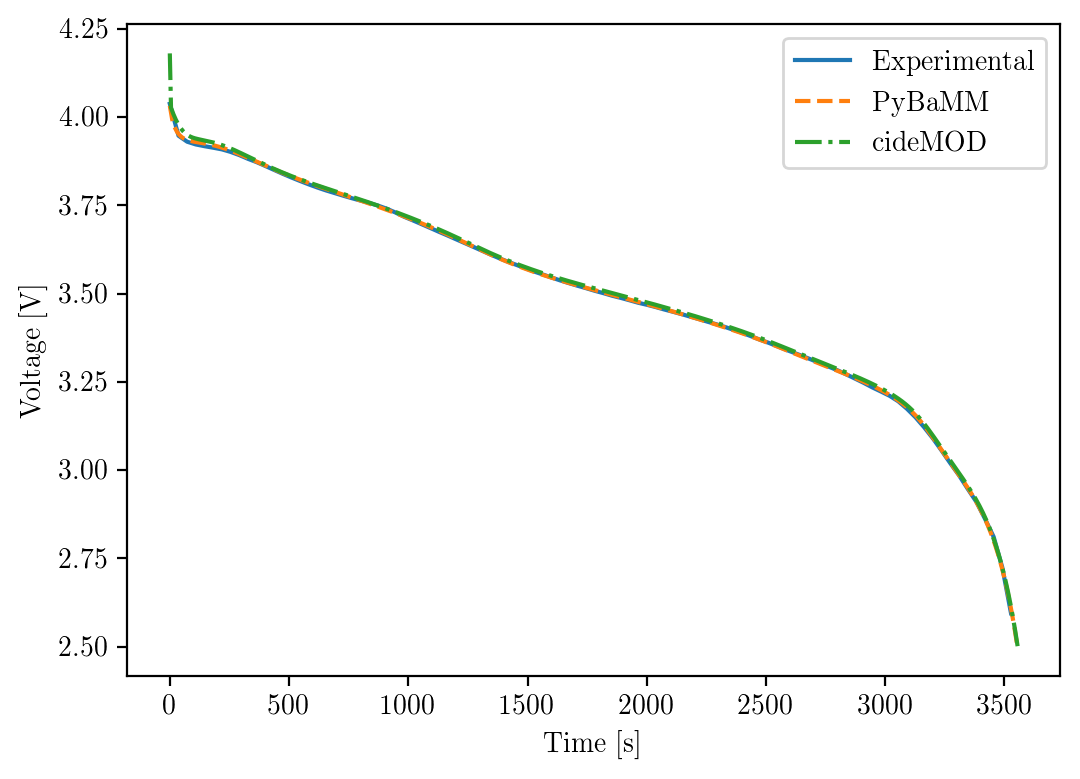

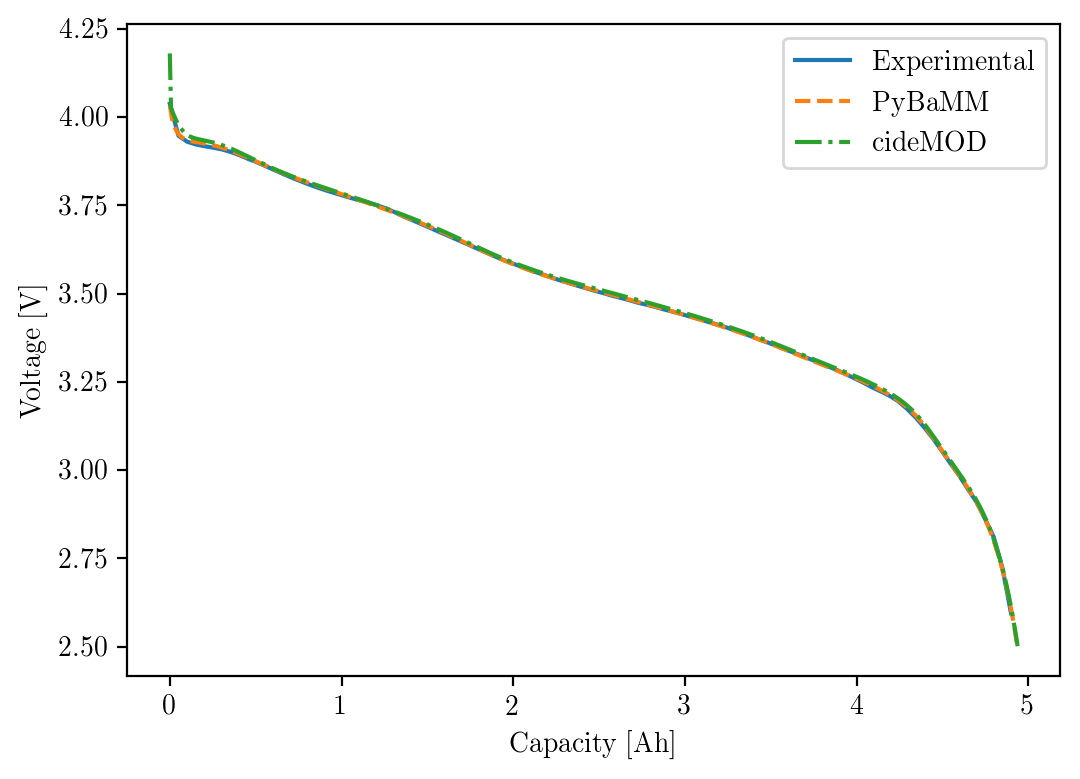

In [6]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

# plot the 1C results over time
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "-")
ax1.plot(voltage_pybamm_1C[:,0], voltage_pybamm_1C[:,2], "--")
ax1.plot(problem.WH.global_var_arrays[0], problem.WH.global_var_arrays[1], "-.")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["Experimental", "PyBaMM", "cideMOD"], loc="best")

plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

# plot the 1C results over capacity
ax1.plot(voltage_data_1C[:,0]*5/3600, voltage_data_1C[:,1], "-")
ax1.plot(voltage_pybamm_1C[:,0]*5/3600, voltage_pybamm_1C[:,2], "--")
ax1.plot(problem.WH.global_var_arrays[3], problem.WH.global_var_arrays[1], "-.")
ax1.set_xlabel("Capacity [Ah]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["Experimental", "PyBaMM", "cideMOD"], loc="best")

plt.tight_layout()
plt.show()

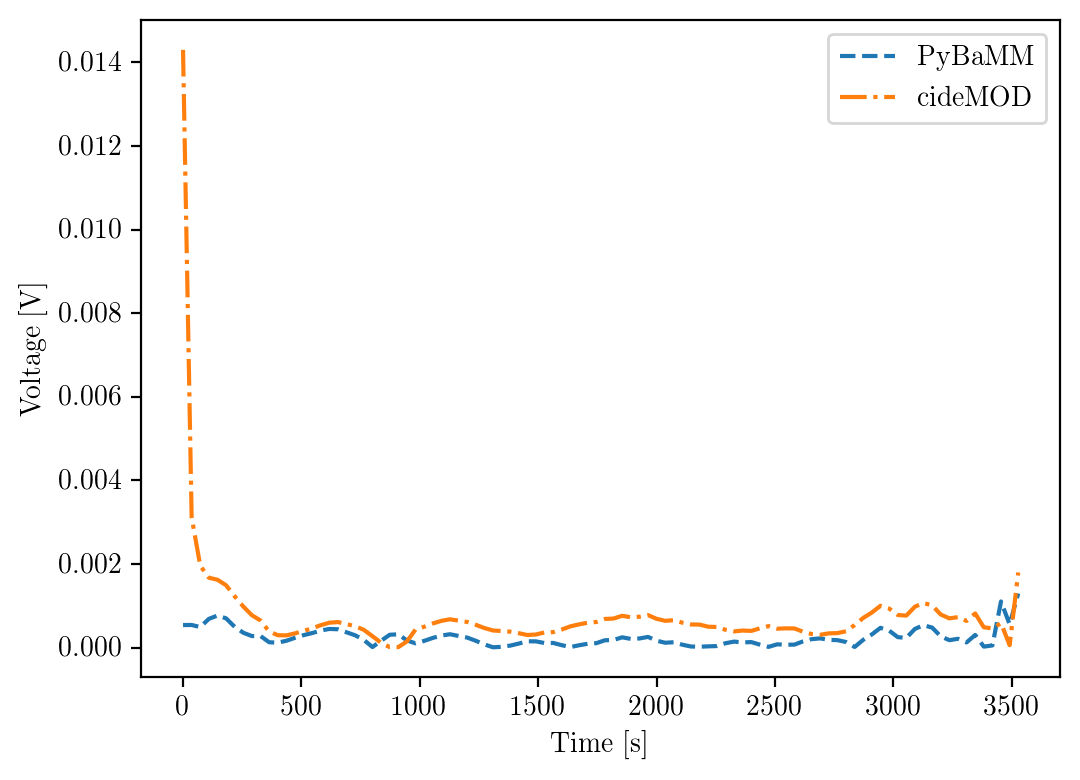

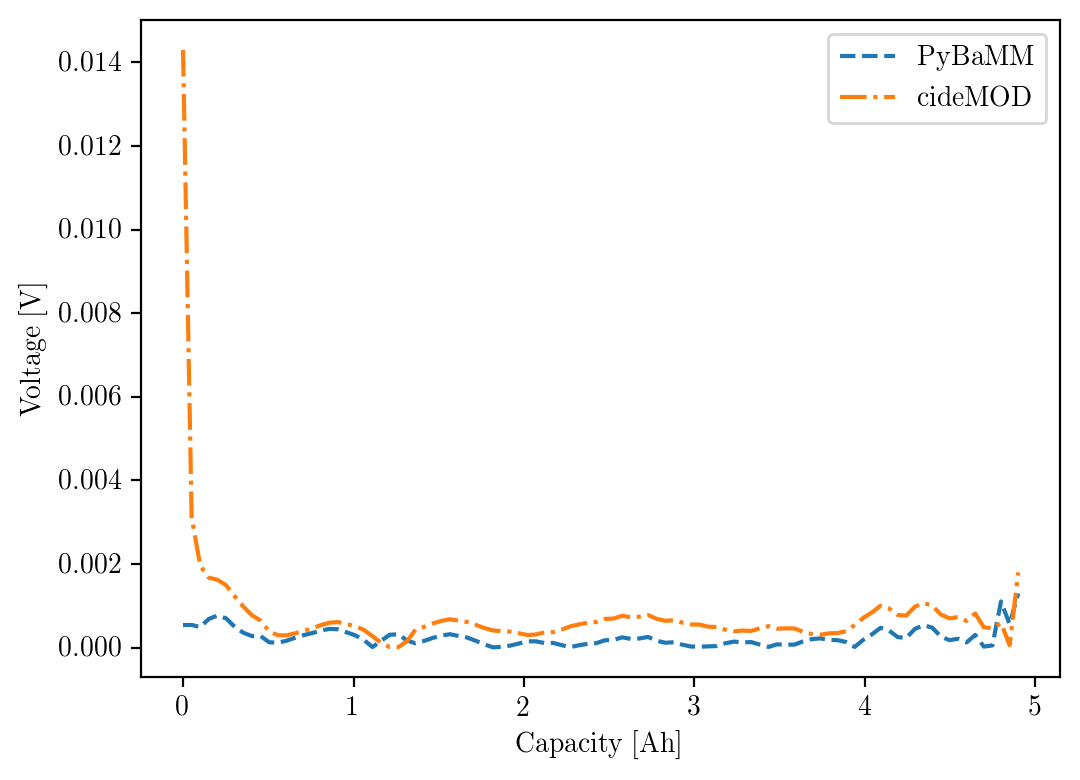

In [7]:
from scipy.interpolate import interp1d
import numpy
real = interp1d(voltage_data_1C[:,0], voltage_data_1C[:,1], bounds_error=False)
pybamm = interp1d(voltage_pybamm_1C[:,0], voltage_pybamm_1C[:,2], bounds_error=False)
cidemod = interp1d(problem.WH.global_var_arrays[0], problem.WH.global_var_arrays[1], bounds_error=False)

time = numpy.linspace(0, 3600, 100)

fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

# plot the RMSE over time
ax1.plot(time, numpy.sqrt((real(time)-pybamm(time))**2/len(time)), "--")
ax1.plot(time, numpy.sqrt((real(time)-cidemod(time))**2/len(time)), "-.")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["PyBaMM", "cideMOD"], loc="best")

plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)

# plot the RMSE over capacity
real = interp1d(voltage_data_1C[:,0]*5/3600, voltage_data_1C[:,1], bounds_error=False)
pybamm = interp1d(voltage_pybamm_1C[:,0]*5/3600, voltage_pybamm_1C[:,2], bounds_error=False)
cidemod = interp1d(problem.WH.global_var_arrays[3], problem.WH.global_var_arrays[1], bounds_error=False)

capacity = numpy.linspace(0, 5, 100)

ax1.plot(capacity, numpy.sqrt((real(capacity)-pybamm(capacity))**2/len(capacity)), "--")
ax1.plot(capacity, numpy.sqrt((real(capacity)-cidemod(capacity))**2/len(capacity)), "-.")
ax1.set_xlabel("Capacity [Ah]")
ax1.set_ylabel("Voltage [V]")
ax1.legend(["PyBaMM", "cideMOD"], loc="best")

plt.tight_layout()
plt.show()